<a href="https://colab.research.google.com/github/samarth2015/writing_assignment/blob/main/Road_safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install streamlit pyngrok

## Data Loading:

**Group members:**

- Praanshu Patel (23110249)
- Samarth Sonawane (23110317)
- Sharvari Mirge (23110298)
- Akshat Shah (23110293)

In [1]:
# Loading the dataset (Making a pandas Dataframe with each row as a country)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Important data in each file:
# Type of data: (col 2)
# - Global loctation (eg-Africa, East Mediterranean, etc.) (col 4: code and col 5: name)
# - Country name (col 7: code and col 8: name)
# Data value (col 30)
# Extra data if present: (col 12: type of data, col 13: data)
# Year of data (col 10)

# Function to load and process the dataset
def load_dataset(file_path):
    # Read the dataset
    df = pd.read_csv(file_path, encoding='UTF-8')

    # Select relevant columns and rename them
    df = df.iloc[:, [1, 3, 4, 6, 7, 9, 11, 12, 29]]
    df.columns = ['Type', 'Global_Location_Code', 'Global_Location_Name',
                  'Country_Code', 'Country_Name', 'Year', 'Data_Type', 'Data_Description', 'Value']


    # Convert Data_Type and Data_Description to '-' if they are NaN
    df['Data_Type'] = df['Data_Type'].fillna('-')
    df['Data_Description'] = df['Data_Description'].fillna('-')

    return df


In [2]:
# Folder containing the dataset files
folder_path = '/content/'

# Loading all the datasets in the folder
import os

files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
files.sort()
dataframes = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = load_dataset(file_path)
    dataframes.append(df)
    display(df.head())  # Display the first few rows of each dataframe

,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Applicability of national motorcycle helmet la...,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Motorcycle Occupant Type,Adult passengers,—
1,Applicability of national motorcycle helmet la...,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Motorcycle Occupant Type,Drivers,—
2,Applicability of national motorcycle helmet la...,AMR,Americas,ATG,Antigua and Barbuda,2017,Motorcycle Occupant Type,Adult passengers,—
3,Applicability of national motorcycle helmet la...,AMR,Americas,ATG,Antigua and Barbuda,2017,Motorcycle Occupant Type,Drivers,—
4,Applicability of national motorcycle helmet la...,AFR,Africa,COM,Comoros,2017,Motorcycle Occupant Type,Adult passengers,—


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Applicability of seat-belt law to all occupants,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,No data
1,Applicability of seat-belt law to all occupants,EUR,Europe,ALB,Albania,2017,-,-,No data
2,Applicability of seat-belt law to all occupants,AFR,Africa,AGO,Angola,2017,-,-,No data
3,Applicability of seat-belt law to all occupants,AMR,Americas,ATG,Antigua and Barbuda,2017,-,-,No data
4,Applicability of seat-belt law to all occupants,AMR,Americas,ARG,Argentina,2017,-,-,No data


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Attribution of road traffic deaths to alcohol (%),EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,–
1,Attribution of road traffic deaths to alcohol (%),AFR,Africa,AGO,Angola,2017,-,-,–
2,Attribution of road traffic deaths to alcohol (%),SEAR,South-East Asia,BGD,Bangladesh,2017,-,-,–
3,Attribution of road traffic deaths to alcohol (%),AMR,Americas,BRB,Barbados,2017,-,-,–
4,Attribution of road traffic deaths to alcohol (%),EUR,Europe,BEL,Belgium,2017,-,-,–


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Availability of funding for national road safe...,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,-,-,−
1,Availability of funding for national road safe...,AMR,Americas,ATG,Antigua and Barbuda,2016,-,-,−
2,Availability of funding for national road safe...,EUR,Europe,ARM,Armenia,2016,-,-,−
3,Availability of funding for national road safe...,EUR,Europe,AZE,Azerbaijan,2016,-,-,−
4,Availability of funding for national road safe...,AMR,Americas,BRB,Barbados,2016,-,-,−


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Blood Alcohol Concentration (BAC) limit for dr...,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Driver Type,General population,-
1,Blood Alcohol Concentration (BAC) limit for dr...,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Driver Type,young/novice drivers,-
2,Blood Alcohol Concentration (BAC) limit for dr...,AMR,Americas,ATG,Antigua and Barbuda,2017,Driver Type,General population,-
3,Blood Alcohol Concentration (BAC) limit for dr...,AMR,Americas,ATG,Antigua and Barbuda,2017,Driver Type,young/novice drivers,-
4,Blood Alcohol Concentration (BAC) limit for dr...,EUR,Europe,AZE,Azerbaijan,2017,Driver Type,General population,-


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Definition of drink-driving by BAC,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,No
1,Definition of drink-driving by BAC,AMR,Americas,ATG,Antigua and Barbuda,2017,-,-,No
2,Definition of drink-driving by BAC,EUR,Europe,AZE,Azerbaijan,2017,-,-,No
3,Definition of drink-driving by BAC,SEAR,South-East Asia,BGD,Bangladesh,2017,-,-,No
4,Definition of drink-driving by BAC,AFR,Africa,BEN,Benin,2017,-,-,No


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Distribution of road traffic deaths by type of...,AFR,Africa,AGO,Angola,2016,Road User Type,Other/unspecified road users,0.0
1,Distribution of road traffic deaths by type of...,AMR,Americas,ATG,Antigua and Barbuda,2016,Road User Type,Drivers/passengers of motorized 2- or 3-wheelers,0.0
2,Distribution of road traffic deaths by type of...,AMR,Americas,ATG,Antigua and Barbuda,2016,Road User Type,Other/unspecified road users,0.0
3,Distribution of road traffic deaths by type of...,AMR,Americas,BRB,Barbados,2016,Road User Type,Cyclists,0.0
4,Distribution of road traffic deaths by type of...,AFR,Africa,BWA,Botswana,2016,Road User Type,Drivers/passengers of motorized 2- or 3-wheelers,0.0


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Estimated number of road traffic deaths,WPR,Western Pacific,NIU,Niue,2021,-,-,0
1,Estimated number of road traffic deaths,EUR,Europe,MCO,Monaco,2021,-,-,0 [0-1]
2,Estimated number of road traffic deaths,WPR,Western Pacific,NRU,Nauru,2021,-,-,1 [1-1]
3,Estimated number of road traffic deaths,EUR,Europe,MLT,Malta,2021,-,-,10 [8-12]
4,Estimated number of road traffic deaths,AFR,Africa,TZA,United Republic of Tanzania,2021,-,-,10 052 [8246-11 858]


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Estimated road traffic death rate (per 100 000...,GLOBAL,Global,HKG,"China, Hong Kong Special Administrative Region",2021,-,-,0.0
1,Estimated road traffic death rate (per 100 000...,GLOBAL,Global,MAC,"China, Macao Special Administrative Region",2021,-,-,0.0
2,Estimated road traffic death rate (per 100 000...,EUR,Europe,MCO,Monaco,2021,-,-,0.0
3,Estimated road traffic death rate (per 100 000...,WPR,Western Pacific,NIU,Niue,2021,-,-,0.0
4,Estimated road traffic death rate (per 100 000...,SEAR,South-East Asia,MDV,Maldives,2021,-,-,1.3


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of a national child-restraint law,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,No
1,Existence of a national child-restraint law,AMR,Americas,ATG,Antigua and Barbuda,2017,-,-,No
2,Existence of a national child-restraint law,EUR,Europe,ARM,Armenia,2017,-,-,No
3,Existence of a national child-restraint law,EUR,Europe,AZE,Azerbaijan,2017,-,-,No
4,Existence of a national child-restraint law,SEAR,South-East Asia,BGD,Bangladesh,2017,-,-,No


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of a national road safety strategy,AFR,Africa,CAF,Central African Republic,2016,-,-,−
1,Existence of a national road safety strategy,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,-,-,No
2,Existence of a national road safety strategy,AMR,Americas,ATG,Antigua and Barbuda,2016,-,-,No
3,Existence of a national road safety strategy,EUR,Europe,ARM,Armenia,2016,-,-,No
4,Existence of a national road safety strategy,EUR,Europe,AZE,Azerbaijan,2016,-,-,No


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of a road safety lead agency,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,-,-,No
1,Existence of a road safety lead agency,EUR,Europe,BEL,Belgium,2016,-,-,No
2,Existence of a road safety lead agency,AFR,Africa,CMR,Cameroon,2016,-,-,No
3,Existence of a road safety lead agency,EUR,Europe,HRV,Croatia,2016,-,-,No
4,Existence of a road safety lead agency,EUR,Europe,DNK,Denmark,2016,-,-,No


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of a universal access telephone numb...,AFR,Africa,CAF,Central African Republic,2016,-,-,-
1,Existence of a universal access telephone numb...,AFR,Africa,TCD,Chad,2016,-,-,-
2,Existence of a universal access telephone numb...,EUR,Europe,MLT,Malta,2016,-,-,-
3,Existence of a universal access telephone numb...,AFR,Africa,AGO,Angola,2016,-,-,"National, multiple numbers"
4,Existence of a universal access telephone numb...,AMR,Americas,BRB,Barbados,2016,-,-,"National, multiple numbers"


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of a national drink-driving law,SEAR,South-East Asia,MDV,Maldives,2017,-,-,No
1,Existence of a national drink-driving law,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,Yes
2,Existence of a national drink-driving law,EUR,Europe,ALB,Albania,2017,-,-,Yes
3,Existence of a national drink-driving law,AFR,Africa,AGO,Angola,2017,-,-,Yes
4,Existence of a national drink-driving law,AMR,Americas,ATG,Antigua and Barbuda,2017,-,-,Yes


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of a national seat-belt law,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,No
1,Existence of a national seat-belt law,AMR,Americas,ATG,Antigua and Barbuda,2017,-,-,No
2,Existence of a national seat-belt law,SEAR,South-East Asia,BGD,Bangladesh,2017,-,-,No
3,Existence of a national seat-belt law,AFR,Africa,BEN,Benin,2017,-,-,No
4,Existence of a national seat-belt law,AFR,Africa,COM,Comoros,2017,-,-,No


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Existence of national speed limits,AFR,Africa,BEN,Benin,2017,-,-,No
1,Existence of national speed limits,AMR,Americas,DMA,Dominica,2017,-,-,No
2,Existence of national speed limits,AFR,Africa,GIN,Guinea,2017,-,-,No
3,Existence of national speed limits,AFR,Africa,TGO,Togo,2017,-,-,No
4,Existence of national speed limits,WPR,Western Pacific,VUT,Vanuatu,2017,-,-,No


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Law requires helmet to be fastened,EMR,Eastern Mediterranean,AFG,Afghanistan,2017,-,-,-
1,Law requires helmet to be fastened,AMR,Americas,ATG,Antigua and Barbuda,2017,-,-,-
2,Law requires helmet to be fastened,AFR,Africa,COM,Comoros,2017,-,-,-
3,Law requires helmet to be fastened,AMR,Americas,DMA,Dominica,2017,-,-,-
4,Law requires helmet to be fastened,AMR,Americas,GUY,Guyana,2017,-,-,-


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Maximum speed limits,AFR,Africa,BEN,Benin,2017,Residence Area Type,Urban,?
1,Maximum speed limits,AFR,Africa,COM,Comoros,2017,Residence Area Type,Urban,?
2,Maximum speed limits,AMR,Americas,DMA,Dominica,2017,Residence Area Type,Urban,?
3,Maximum speed limits,AFR,Africa,GIN,Guinea,2017,Residence Area Type,Urban,?
4,Maximum speed limits,AMR,Americas,HND,Honduras,2017,Residence Area Type,Urban,?


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Seat-belt wearing rate (%),EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Seat Type,All occupants,NaN
1,Seat-belt wearing rate (%),EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Seat Type,Drivers only,NaN
2,Seat-belt wearing rate (%),EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Seat Type,Front seat,NaN
3,Seat-belt wearing rate (%),EMR,Eastern Mediterranean,AFG,Afghanistan,2017,Seat Type,Rear seat,NaN
4,Seat-belt wearing rate (%),AMR,Americas,ATG,Antigua and Barbuda,2017,Seat Type,All occupants,NaN


,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Vehicle standards,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,Vehicle standards,Child seats,No
1,Vehicle standards,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,Vehicle standards,Electronic stability control,No
2,Vehicle standards,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,Vehicle standards,Frontal impact,No
3,Vehicle standards,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,Vehicle standards,Motorcycle,No
4,Vehicle standards,EMR,Eastern Mediterranean,AFG,Afghanistan,2016,Vehicle standards,Pedestrian protection,No


## Get summary of any country

In [3]:
# merge all the dfs
df = pd.concat(dataframes, ignore_index=True)
# save the data in csv file
df.to_csv('merged_dataset.csv', index=False)

In [19]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [21]:
from IPython.display import IFrame
import subprocess
import time

# Run the Streamlit app
subprocess.Popen(["streamlit", "run", "/content/app.py"])

# Give Streamlit a few seconds to start
time.sleep(5)

# Display inside notebook (port must match the one Streamlit uses)
IFrame(src='http://localhost:8501', width=1200, height=720)


## Helmet and seatbelt laws (and their enforcement) with motorcycle-related road traffic deaths.

### Are Road Safety Laws strictly implemented?

Every year, over a million lives are lost due to road crashes. But behind these numbers lies a critical question:

**Do laws actually save lives, or are they just ink on paper?**

In this notebook, we explore two key questions:
1. How strict are helmet and seatbelt laws across countries?
2. Are stronger laws associated with fewer deaths among motorcyclists?

Let's find out.


In [4]:

helmet_laws = dataframes[0]
helmet_fastened = dataframes[-4]
seatbelt_laws = dataframes[1]
national_seatbelt_law = dataframes[-6]
death_distribution = dataframes[6]


To begin, we explore the legal landscape:

- Which countries require helmets for all motorcycle users?
- Are helmets legally required to be fastened?
- What about rear seatbelt laws?

In [5]:
# Filter for adult passengers and drivers
helmet_all = helmet_laws[helmet_laws['Data_Description'].isin(['Drivers', 'Adult passengers'])]

# Count countries that have helmet laws for both
helmet_status = helmet_all.groupby('Country_Code')['Value'].apply(lambda x: all(val == 'Yes' for val in x)).reset_index()
helmet_status.columns = ['Country_Code', 'Helmet_Law_All_Occupants']
helmet_status['Helmet_Law_All_Occupants'] = helmet_status['Helmet_Law_All_Occupants'].astype(int)  # 1 = Yes, 0 = No

helmet_status.head()


,Country_Code,Helmet_Law_All_Occupants
0,AFG,0
1,AGO,1
2,ALB,1
3,ARE,1
4,ARG,1


In [6]:
helmet_fastened['Helmet_Fastened'] = helmet_fastened['Value'].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0)
helmet_fastened = helmet_fastened[['Country_Code', 'Helmet_Fastened']]
helmet_fastened.head()


,Country_Code,Helmet_Fastened
0,AFG,0
1,ATG,0
2,COM,0
3,DMA,0
4,GUY,0


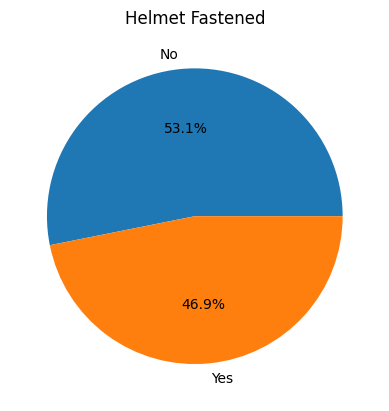

In [7]:
plt.pie(helmet_fastened['Helmet_Fastened'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title('Helmet Fastened')
plt.show()

In [8]:
helmet_data = pd.merge(helmet_status, helmet_fastened, on='Country_Code', how='inner')
helmet_data.head()


,Country_Code,Helmet_Law_All_Occupants,Helmet_Fastened
0,AFG,0,0
1,AGO,1,1
2,ALB,1,0
3,ARE,1,0
4,ARG,1,1


#### Insight: Strictness of Helmet Laws

We define a country as having a **strict helmet law** if it:
- Applies to both drivers and adult passengers, AND
- Requires helmets to be fastened.


In [9]:
helmet_data["Strict_Helmet_Law"] = helmet_data.apply(
    lambda row: 1 if row["Helmet_Law_All_Occupants"] == 1 and row["Helmet_Fastened"] == 1 else 0, axis=1
)
helmet_data.head()

,Country_Code,Helmet_Law_All_Occupants,Helmet_Fastened,Strict_Helmet_Law
0,AFG,0,0,0
1,AGO,1,1,1
2,ALB,1,0,0
3,ARE,1,0,0
4,ARG,1,1,1


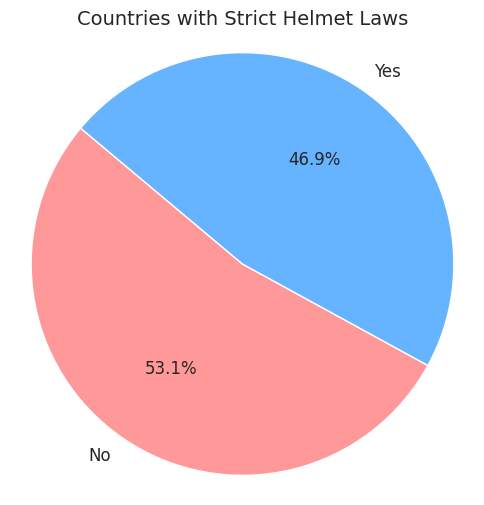

In [10]:
# Optional: apply seaborn style
sns.set_theme(style="whitegrid")

# Count values
helmet_counts = helmet_data['Strict_Helmet_Law'].value_counts().sort_index()

# Labels and colors
labels = ['No', 'Yes']
colors = ['#ff9999', '#66b3ff']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(
    helmet_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)

plt.title("Countries with Strict Helmet Laws", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()


### Do Laws Work?

Let’s now explore the link between the laws and actual motorcycle-related fatalities.

We'll use the % of road traffic deaths that are motorcyclists as a proxy for vulnerability.


In [11]:
moto_deaths = death_distribution[death_distribution['Data_Description'] == 'Drivers/passengers of motorized 2- or 3-wheelers']
moto_deaths = moto_deaths[['Country_Code', 'Value']]
moto_deaths.columns = ['Country_Code', 'Motorcyclist_Death_Percentage']
moto_deaths['Motorcyclist_Death_Percentage'] = pd.to_numeric(moto_deaths['Motorcyclist_Death_Percentage'], errors='coerce')


In [12]:
moto_deaths

,Country_Code,Motorcyclist_Death_Percentage
1,ATG,0.0
4,BWA,0.0
11,DMA,0.0
16,JOR,0.0
30,FSM,0.0
...,...,...
633,SWZ,2.0
637,NIC,26.0
648,AND,50.0
653,MHL,66.7


In [13]:
law_vs_deaths = pd.merge(helmet_data, moto_deaths, on='Country_Code', how='inner')
law_vs_deaths.dropna(inplace=True)

law_vs_deaths.head()


,Country_Code,Helmet_Law_All_Occupants,Helmet_Fastened,Strict_Helmet_Law,Motorcyclist_Death_Percentage
0,ALB,1,0,0,11.9
1,ARE,1,0,0,5.5
2,ARG,1,1,1,22.2
3,ARM,1,1,1,1.5
4,ATG,0,0,0,0.0


In [14]:
import plotly.express as px

In [15]:
law_vs_deaths['Strict_Helmet_Law_Label'] = law_vs_deaths['Strict_Helmet_Law'].map({0: 'No Strict Law', 1: 'Strict Law'})

fig = px.box(
    law_vs_deaths,
    x='Strict_Helmet_Law_Label',
    y='Motorcyclist_Death_Percentage',
    color='Strict_Helmet_Law_Label',
    color_discrete_map={'No Strict Law': '#ff9999', 'Strict Law': '#66b3ff'},
    points="all",
    hover_data=['Country_Code']
)

fig.update_layout(
    title="Motorcyclist Deaths vs. Strict Helmet Laws",
    xaxis_title="Strict Helmet Law",
    yaxis_title="Motorcyclist Deaths (% of total)",
    showlegend=False,
    template="plotly_white"
)

fig.show()


In [16]:
# Prepare data
sunburst_df = helmet_data.copy()
sunburst_df['Strict_Helmet_Law_Label'] = sunburst_df['Strict_Helmet_Law'].map({1: 'Strict Law', 0: 'No Strict Law'})

# Fill missing region if needed
sunburst_df = sunburst_df.dropna(subset=['Country_Code'])

# Plot sunburst
fig = px.sunburst(
    sunburst_df,
    path=['Strict_Helmet_Law_Label', 'Helmet_Fastened', 'Country_Code'],
    values=None,
    color='Strict_Helmet_Law_Label',
    color_discrete_map={'Strict Law': '#66b3ff', 'No Strict Law': '#ff9999'},
    title="Layers of Helmet Safety Laws Across Regions",
    width=700,
    height=600
)

fig.update_traces(textinfo='label+percent entry')
fig.show()


In [17]:
fig = px.scatter(
    law_vs_deaths,
    x='Strict_Helmet_Law',
    y='Motorcyclist_Death_Percentage',
    color='Strict_Helmet_Law',
    text='Country_Code',
    color_discrete_map={1: '#66b3ff', 0: '#ff9999'},
    title='Motorcyclist Death % vs Helmet Law Strictness'
)

fig.update_traces(textposition='top center')
fig.update_layout(
    xaxis=dict(tickvals=[0, 1], ticktext=["No Strict Law", "Strict Law"]),
    yaxis_title="Motorcyclist Death Percentage"
)
fig.show()


#### Poor enforcement of laws

**Countries below have the more than 40% of motorcyclist deaths despite of having strict laws**
- THA - Thailand
- MMR - Myanmar
- BEN - Benin
- PRY - Paraguay
- SUR - Suriname
- SGP - Singapore
- MLI - Mali
- IND - India

### Alcohol Inferences:


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# World map using chloropleth for % deaths due to alcohol in each country/region

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

# Load the dataset
df = pd.read_csv('merged_dataset.csv')

# Relevant values in 'Type' column:
# Attribution of deaths to alcohol
# Estimated number of road traffic deaths
# We will use only the rows with both and calculate the percentage of deaths due to alcohol for each country/region

# Filter the dataset for relevant types
dfe = df[df['Type'].isin(['Estimated number of road traffic deaths'])]
dfe.reset_index(drop=True, inplace=True)

# The data in 'Value' for Estimated number of road traffic deaths is in the form 10 [8-12] i.e. average [low-high]
# We need to convert this to a numeric value for calculations
def extract_value(value):
    if '[' in value:
        # Extract the average value from the range
        if "[" in value:
            avg_value = value.split('[')[0].strip()
            # Remove any spaces or commas
            avg_value = avg_value.replace(' ', '').replace(',', '')
            # Convert to float
            avg_value = float(avg_value)
        else:
            avg_value = float(value)
        return avg_value
    else:
        return float(value)

# Apply the function to the 'Estimated number of road traffic deaths' values
dfe['Value'] = dfe['Value'].apply(extract_value)
display(dfe.head()) 

# Create a pivot table to get the values for each country/region
pivot_table_e = dfe.pivot_table(index=['Country_Code', 'Country_Name'], columns='Type', values='Value', aggfunc='mean').reset_index()

display(pivot_table_e.head())  # Display the first few rows of the pivot table

,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Estimated number of road traffic deaths,WPR,Western Pacific,NIU,Niue,2021,-,-,0.0
1,Estimated number of road traffic deaths,EUR,Europe,MCO,Monaco,2021,-,-,0.0
2,Estimated number of road traffic deaths,WPR,Western Pacific,NRU,Nauru,2021,-,-,1.0
3,Estimated number of road traffic deaths,EUR,Europe,MLT,Malta,2021,-,-,10.0
4,Estimated number of road traffic deaths,AFR,Africa,TZA,United Republic of Tanzania,2021,-,-,10052.0


Type,Country_Code,Country_Name,Estimated number of road traffic deaths
0,AFG,Afghanistan,9684.0
1,AGO,Angola,5188.0
2,ALB,Albania,309.0
3,AND,Andorra,2.0
4,ARE,United Arab Emirates,557.0


In [3]:
# The percentage of deaths due to alcohol is given in the 'Attribution of deaths to alcohol' column
# We will use this to calculate the percentage of deaths due to alcohol for each country/region
import numpy as np
from IPython.display import IFrame



# Filter the dataset for relevant types
dfap = df[df['Type'].isin(['Attribution of road traffic deaths to alcohol (%)'])]

# Convert the 'Value' column to numeric values and handling exceptions that contain some letters
# The rest of the data is a float value in a string format (there is no range like previously)

def extract_value(value):
    if value=='–':
        value = np.nan
    else:
        value = float(value.split(' ')[0])
    return value
    
dfap['Value'] = dfap['Value'].apply(extract_value)
# Drop nan
dfap.dropna(subset=['Value'], inplace=True)

# reset index
dfap.reset_index(drop=True, inplace=True)
display(dfap.head())

# Create a pivot table to get the values for each country/region
pivot_table_ap = dfap.pivot_table(index=['Country_Code', 'Country_Name'], columns='Type', values='Value', aggfunc='mean').reset_index()
display(pivot_table_ap.head())  # Display the first few rows of the pivot table

# Make the world map using plotly express
# Create a world map using Plotly Express

fig = px.choropleth(pivot_table_ap,
                    locations='Country_Code',
                    locationmode='ISO-3',
                    color='Attribution of road traffic deaths to alcohol (%)',
                    hover_name='Country_Name',
                    title='Percentage of Road Traffic Deaths Attributed to Alcohol by Country/Region',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    labels={'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'}
                   )
fig.update_geos(projection_type='natural earth')
fig.update_layout(title_x=0.5)  # Center the title

fig.show()

,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Attribution of road traffic deaths to alcohol (%),WPR,Western Pacific,MYS,Malaysia,2017,-,-,0.1
1,Attribution of road traffic deaths to alcohol (%),EUR,Europe,KAZ,Kazakhstan,2017,-,-,0.3
2,Attribution of road traffic deaths to alcohol (%),EMR,Eastern Mediterranean,SDN,Sudan,2017,-,-,0.3
3,Attribution of road traffic deaths to alcohol (%),WPR,Western Pacific,CHN,China,2017,-,-,0.4
4,Attribution of road traffic deaths to alcohol (%),AFR,Africa,MLI,Mali,2017,-,-,0.4


Type,Country_Code,Country_Name,Attribution of road traffic deaths to alcohol (%)
0,ALB,Albania,5.2
1,ARE,United Arab Emirates,1.8
2,ARG,Argentina,17.0
3,ARM,Armenia,1.9
4,ATG,Antigua and Barbuda,0.9


In [4]:
# Bubble chart:
#X-axis: BAC limit (lower = stricter)
#Y-axis: % of deaths due to alcohol
#Size: total traffic deaths
#Color: Country

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio

# Using % deaths due to alcohol from the previous dfap dataframe
# Using size of total traffic deaths from the dfe dataframe

# Using BAC limit from the df dataframe
# Filter the dataset for relevant types
dfbac = df[df['Type'].isin(['Blood Alcohol Concentration (BAC) limit for drivers'])]
# The data is in the form: - if there is no limit
# Of the form <0.05 g/dl if there is a limit (< can also be <=)
# There is no < or <= if limit is 0 g/dl
# Some are of the form: 0.00 - 0.08 g/dl

# We will use the upper limit for the BAC limit

def extract_value(value):
    if value == '-':
        value = np.nan
    elif '=' in value:
        value = value.split('=')[1].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    elif '<' in value:
        value = value.split('<')[1].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    elif '-' in value:
        value = value.split('-')[1].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    else:
        value = value.split(' ')[0].strip()
        value = value.replace('g/dl', '').replace(' ', '').replace(',', '')
    
    return float(value)

# Apply the function to the 'Blood Alcohol Concentration (BAC) limit for drivers' values
dfbac['Value'] = dfbac['Value'].apply(extract_value)
# Drop nan
dfbac.dropna(subset=['Value'], inplace=True)

# reset index
dfbac.reset_index(drop=True, inplace=True)
display(dfbac.head())

# Create a pivot table to get the values for each country/region
pivot_table_bac = dfbac.pivot_table(index=['Country_Code', 'Country_Name'], columns='Type', values='Value', aggfunc='mean').reset_index()
display(pivot_table_bac.head())  # Display the first few rows of the pivot table

# Merge the dataframes to get the BAC limit, % deaths due to alcohol and total traffic deaths in one dataframe
# Merge the dataframes on Country_Code and Country_Name

merged_df = pd.merge(pivot_table_ap, pivot_table_bac, on=['Country_Code', 'Country_Name'], how='inner')
merged_df = pd.merge(merged_df, pivot_table_e, on=['Country_Code', 'Country_Name'], how='inner')
display(merged_df.head())  # Display the first few rows of the merged dataframe

# Make the bubble chart using plotly express

# scale the size of the bubbles to be more manageable
merged_df['Scaled Deaths'] = merged_df['Estimated number of road traffic deaths'] / 1000

# Sort so that large bubbles go behind
merged_df = merged_df.sort_values('Scaled Deaths', ascending=False)
fig1 = px.scatter(
    merged_df,
    x='Blood Alcohol Concentration (BAC) limit for drivers',
    y='Attribution of road traffic deaths to alcohol (%)',
    #size='Scaled Deaths',  # scaled size
    color='Country_Name',  # each country gets a unique color
    hover_name='Country_Name',
    title='Bubble Chart: BAC Limit vs % Deaths Due to Alcohol',
    labels={
        'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit (g/dl)',
        'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'
    },
    size_max=30,  # reduce max size
    height=600,
)

fig1.update_traces(marker=dict(sizemode='diameter', opacity=0.7, line_width=1))
fig1.update_layout(
    title_x=0.5,
    legend_title_text='Country',
    showlegend=True  # set True if you want a clickable color legend
)

fig1.show()

fig = px.scatter(
    merged_df,
    x='Blood Alcohol Concentration (BAC) limit for drivers',
    y='Attribution of road traffic deaths to alcohol (%)',
    size='Scaled Deaths',  # scaled size
    color='Country_Name',  # each country gets a unique color
    hover_name='Country_Name',
    title='Bubble Chart: BAC Limit vs % Deaths Due to Alcohol (with size of bubble as Total Deaths)',
    labels={
        'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit (g/dl)',
        'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'
    },
    size_max=30,  # reduce max size
    height=600,
)

fig.update_traces(marker=dict(sizemode='diameter', opacity=0.7, line_width=1))
fig.update_layout(
    title_x=0.5,
    legend_title_text='Country',
    showlegend=True  # set True if you want a clickable color legend
)

fig.show()

,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Blood Alcohol Concentration (BAC) limit for dr...,EUR,Europe,MKD,North Macedonia,2017,Driver Type,young/novice drivers,0.01
1,Blood Alcohol Concentration (BAC) limit for dr...,EUR,Europe,CHE,Switzerland,2017,Driver Type,young/novice drivers,0.01
2,Blood Alcohol Concentration (BAC) limit for dr...,EUR,Europe,LUX,Luxembourg,2017,Driver Type,young/novice drivers,0.02
3,Blood Alcohol Concentration (BAC) limit for dr...,EUR,Europe,POL,Poland,2017,Driver Type,General population,0.02
4,Blood Alcohol Concentration (BAC) limit for dr...,EUR,Europe,POL,Poland,2017,Driver Type,young/novice drivers,0.02


Type,Country_Code,Country_Name,Blood Alcohol Concentration (BAC) limit for drivers
0,AGO,Angola,0.06
1,ALB,Albania,0.05
2,ARE,United Arab Emirates,0.01
3,ARG,Argentina,0.05
4,ARM,Armenia,0.04


Type,Country_Code,Country_Name,Attribution of road traffic deaths to alcohol (%),Blood Alcohol Concentration (BAC) limit for drivers,Estimated number of road traffic deaths
0,ALB,Albania,5.2,0.050,309.0
1,ARE,United Arab Emirates,1.8,0.010,557.0
2,ARG,Argentina,17.0,0.050,3983.0
3,ARM,Armenia,1.9,0.040,379.0
4,AUS,Australia,17.0,0.025,1163.0


Type,BAC Limit,Deaths Due to Alcohol (%),Total Deaths
0,0.020,0.4,248.099
1,0.030,4.1,205.894
2,0.080,29.0,47.750
3,0.026,0.5,36.722
4,0.080,4.3,21.258


                                OLS Regression Results                               
Dep. Variable:     Deaths Due to Alcohol (%)   R-squared:                       0.003
Model:                                   OLS   Adj. R-squared:                 -0.010
Method:                        Least Squares   F-statistic:                    0.2138
Date:                       Sun, 13 Apr 2025   Prob (F-statistic):              0.645
Time:                               13:44:23   Log-Likelihood:                -321.39
No. Observations:                         79   AIC:                             646.8
Df Residuals:                             77   BIC:                             651.5
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

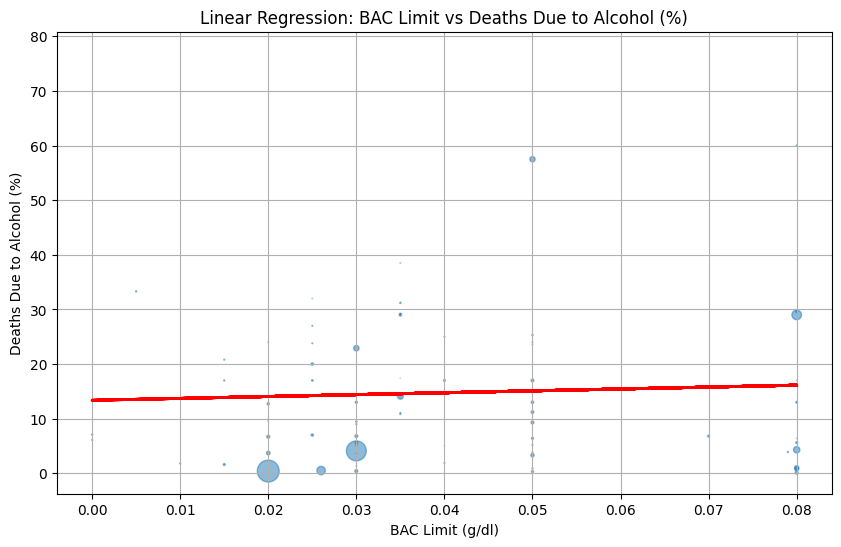

In [5]:
# regression line for the bubble chart
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Data for regression: merged_df dataframe
# X: BAC limit (g/dl)
# Y: % deaths due to alcohol
# Size: total traffic deaths (scaled)
# Color: Country
# We will use the scaled size for the regression line

# Create a new dataframe with the relevant columns
regression_df = merged_df[['Blood Alcohol Concentration (BAC) limit for drivers',
                             'Attribution of road traffic deaths to alcohol (%)',
                             'Scaled Deaths']].copy()
regression_df.rename(columns={'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit',
                               'Attribution of road traffic deaths to alcohol (%)': 'Deaths Due to Alcohol (%)',
                               'Scaled Deaths': 'Total Deaths'}, inplace=True)
# Drop rows with NaN values
regression_df.dropna(inplace=True)
# Reset index
regression_df.reset_index(drop=True, inplace=True)
display(regression_df.head())

# Create a linear regression model
X = regression_df['BAC Limit']
Y = regression_df['Deaths Due to Alcohol (%)']
X = sm.add_constant(X)  # Add a constant term to the predictor

model = sm.OLS(Y, X).fit()  # Fit the model
predictions = model.predict(X)  # Make predictions

# Print the summary of the model
print(model.summary())

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X['BAC Limit'], Y, s=regression_df['Total Deaths'], alpha=0.5)
plt.plot(X['BAC Limit'], predictions, color='red', linewidth=2)
plt.xlabel('BAC Limit (g/dl)')
plt.ylabel('Deaths Due to Alcohol (%)')
plt.title('Linear Regression: BAC Limit vs Deaths Due to Alcohol (%)')
plt.grid()
plt.show()

In [6]:
# Bar plot for Number of countries vs Availability of funding for national road safety strategy
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# The data is the rows with Type: Availability of funding for national road safety strategy
# The data is in the form: - if there is no data
# the rest are in the 3 class: - Not funded, - Partially funded, - Fully funded

# We will use the number of countries in each class to make the bar plot
# Filter the dataset for relevant types
df_funding = df[df['Type'].isin(['Availability of funding for national road safety strategy'])]

def extract_value(value):
    if value == '−':
        value = np.nan
    else:
        value = value
    
    return value

# Apply the function to the 'Availability of funding for national road safety strategy' values
df_funding['Value'] = df_funding['Value'].apply(extract_value)
# Drop nan
df_funding.dropna(subset=['Value'], inplace=True)
# reset index
df_funding.reset_index(drop=True, inplace=True)
display(df_funding.head())

# Bar plot for Number of countries vs Availability of funding for national road safety strategy
# Create a new dataframe with the relevant columns
funding_df = df_funding[['Country_Code', 'Country_Name', 'Value']].copy()
funding_df.rename(columns={'Value': 'Funding'}, inplace=True)

# Count the number of countries in each class
funding_count = funding_df['Funding'].value_counts().reset_index()
funding_count.columns = ['Funding', 'Count']

# Make the bar plot using plotly express
fig = px.bar(funding_count,
             x='Funding',
             y='Count',
             title='Number of Countries vs Availability of Funding for National Road Safety Strategy',
             labels={'Funding': 'Availability of Funding', 'Count': 'Number of Countries'},
             color='Funding',
             color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(title_x=0.5)  # Center the title
fig.show()



# Using fig 1 but with color as funding

# Modify the dataframe to include the funding information
merged_df2 = merged_df.copy()
merged_df2 = pd.merge(merged_df2, funding_df, on=['Country_Code', 'Country_Name'], how='inner')
#display(merged_df2.head())  # Display the first few rows of the merged dataframe

fig1 = px.scatter(
    merged_df2,
    x='Blood Alcohol Concentration (BAC) limit for drivers',
    y='Attribution of road traffic deaths to alcohol (%)',
    #size='Scaled Deaths',  # scaled size
    color='Funding',  # each country gets a unique color
    hover_name='Country_Name',
    title='Bubble Chart: BAC Limit vs % Deaths Due to Alcohol (with size of bubble as Total Deaths)',
    labels={
        'Blood Alcohol Concentration (BAC) limit for drivers': 'BAC Limit (g/dl)',
        'Attribution of road traffic deaths to alcohol (%)': 'Percentage of Deaths Due to Alcohol'
    },
    size_max=30,  # reduce max size
    height=600,
)
fig1.update_traces(marker=dict(sizemode='diameter', opacity=0.7, line_width=1))
fig1.update_layout(
    title_x=0.5,
    legend_title_text='Country',
    showlegend=True  # set True if you want a clickable color legend
)
fig1.show()

,Type,Global_Location_Code,Global_Location_Name,Country_Code,Country_Name,Year,Data_Type,Data_Description,Value
0,Availability of funding for national road safe...,AMR,Americas,ARG,Argentina,2016,-,-,Fully funded
1,Availability of funding for national road safe...,AFR,Africa,BWA,Botswana,2016,-,-,Fully funded
2,Availability of funding for national road safe...,AFR,Africa,CIV,Cote d'Ivoire,2016,-,-,Fully funded
3,Availability of funding for national road safe...,AMR,Americas,CRI,Costa Rica,2016,-,-,Fully funded
4,Availability of funding for national road safe...,EUR,Europe,HRV,Croatia,2016,-,-,Fully funded
